In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# 绘图时输出高清矢量图    
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

**准备训练样本**
- 样本数：10000，输入特征：X1，X2，X3；  输出特征：Y1，Y2，Y3 （ps：实际上输出特征组合起来是One-Hot编码）
1. X  = X1 + X2 + X3
2. 当 X < 1 --------- Y1 为 1，否则 Y1 为 0
3. 当 1 < X < 2 ----- Y2 为 1，否则 Y2 为 0
4. 当 2 < X --------- Y3 为 1，否则 Y3 为 0
5. .float()将布尔型张量转化为浮点型张量，保证数据类型统一，用于打包数据
6. 每个输入特征相互独立，均服从均匀分布

In [3]:
X1 = torch.rand(10000, 1)   # 输入特征 1
X2 = torch.rand(10000, 1)   # 输入特征 2
X3 = torch.rand(10000, 1)   # 输入特征 3
Y1 = ((X1 + X2 + X3) < 1).float()                             # 输出特征 1
Y2 = ((1 < (X1 + X2 + X3)) & ((X1 + X2 + X3) < 2)).float()    # 输出特征 2
Y3 = (2 < (X1 + X2 + X3)).float()                             # 输出特征 3
Data = torch.cat([X1, X2, X3, Y1, Y2, Y3], axis=1)                             # 打包数据，cat等于 numpy里的 concatenate
Data = Data.to('cuda:0')                                                       # 数据转移至 GPU，（模型要和数据一起转移）
Data.shape

torch.Size([10000, 6])

In [4]:
# 划分训练集与测试集 （分割通用代码）
train_size = int(len(Data) * 0.7)                # 训练集的样本数量
test_size = len(Data) - train_size               # 测试集的样本数量
Data = Data[torch.randperm(Data.size(0)), : ]    # 打乱样本的顺序
train_Data = Data[ :train_size, : ]              # 训练集样本
test_Data = Data[train_size: , : ]              # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

**搭建神经网络**

In [5]:
# 搭建父类
class DNN(nn.Module):               # DNN:自定义父类名，以 nn.Module定义父类，包含网络各个层的定义
    def __init__(self):
        ''' 搭建神经网络 '''
        super(DNN, self).__init__()
        self.net = nn.Sequential(             # 按顺序搭建连接，net为自定义名字
            nn.Linear(3, 5), nn.ReLU(),       # 链接 1，数据节点：3（输入层），5（处理层）； 激活函数：nn.ReLU()
            nn.Linear(5, 5), nn.ReLU(),       # 链接 2，数据节点：5（处理层），5（处理层）； 激活函数：nn.ReLU()
            nn.Linear(5, 5), nn.ReLU(),       # 链接 3，数据节点：5（处理层），5（处理层）； 激活函数：nn.ReLU()
            nn.Linear(5, 3))                  # 链接 4，数据节点：5（处理层），3（输出层）

    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x)         # x 输入
        return y                # y 输出

In [6]:
# 模型搬到 GPU                                             cmd终端输入nvidia-smi，查看GPU信息
model = DNN().to('cuda:0')
model

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [7]:
# 查看内部参数（非必要）                requires_grad=True说明打开了梯度计算功能
for name, param in model.named_parameters():
    print(f" 参数:{name}\n 形状:{param.shape}\n 数值:{param}\n ")

 参数:net.0.weight
 形状:torch.Size([5, 3])
 数值:Parameter containing:
tensor([[ 0.2897, -0.2030,  0.4476],
        [-0.0098, -0.4831, -0.5023],
        [-0.5392,  0.1611,  0.2182],
        [-0.4987,  0.2521,  0.3856],
        [ 0.5653, -0.4842, -0.2787]], device='cuda:0', requires_grad=True)
 
 参数:net.0.bias
 形状:torch.Size([5])
 数值:Parameter containing:
tensor([ 0.1157,  0.2097,  0.1733, -0.0118, -0.4999], device='cuda:0',
       requires_grad=True)
 
 参数:net.2.weight
 形状:torch.Size([5, 5])
 数值:Parameter containing:
tensor([[ 0.3153, -0.2898, -0.3856,  0.1005,  0.3331],
        [ 0.2564, -0.0908, -0.4338, -0.1961,  0.2543],
        [ 0.3267,  0.4390,  0.3766,  0.4371, -0.0694],
        [-0.3151,  0.2255, -0.3800, -0.2905,  0.3735],
        [ 0.0910,  0.2060, -0.2242,  0.2164, -0.3184]], device='cuda:0',
       requires_grad=True)
 
 参数:net.2.bias
 形状:torch.Size([5])
 数值:Parameter containing:
tensor([-0.4303, -0.1597,  0.3691, -0.1968,  0.2491], device='cuda:0',
       requires_grad=True)
 

**外部参数**

[torch文档](https://pytorch.org/docs/stable/nn.html)

In [8]:
# 激活函数  （文档索引：Non-linear Activations）

In [9]:
# 选择损失函数  （文档索引：Loss Functions）
loss_fn = nn.MSELoss()

In [10]:
# 优化算法  （文档索引：torch.optim）
learning_rate = 0.01                 # 设置学习率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)    #  torch.optim.SGD 只表示梯度下降

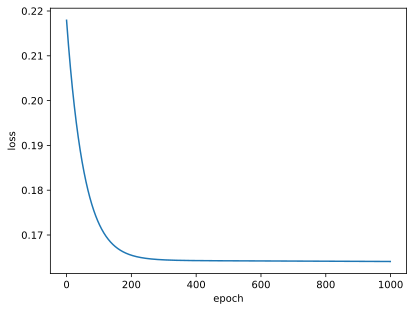

In [11]:
# 训练网络
epochs = 1000   # 训练次数：1000次
losses = []     # 记录损失函数变化的列表
 
X = train_Data[ : ,  :3]   # 前 3 列为输入特征    train_Data-----7000行，6列 [X1, X2, X3, Y1, Y2, Y3]
Y = train_Data[ : ,-3: ]   # 后 3 列为输出特征

for epoch in range(epochs):
    Pred = model(X)          # 一次前向传播（批量 BGD）
    loss = loss_fn(Pred, Y)    # 计算损失函数
    losses.append(loss.item())   # 记录损失函数的变化  .append()是指在列表 losses后再附加 1个元素（损失函数），而.item()方法可将张量变为普通元素
    optimizer.zero_grad()          # 清理上一轮滞留的梯度
    loss.backward()                  # 一次反向传播
    optimizer.step()                   # 优化内部参数

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss'), plt.xlabel('epoch')
plt.show()

In [13]:
# 测试网络
X = test_Data[:, :3]   # 前 3 列为输入特征
Y = test_Data[:, -3:]  # 后 3 列为输出特征
with torch.no_grad():  # 该局部关闭梯度计算功能
    Pred = model(X)        # 一次前向传播（批量）
    Pred[:,torch.argmax(Pred, axis=1)] = 1
    Pred[Pred!=1] = 0
    correct = torch.sum( (Pred == Y).all(1) )   # 预测正确的样本
    total = Y.size(0)    # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 67.0999984741211 %
